In [2]:
!unzip /content/CMP_facade_DB_base.zip
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import os
import sys
import numpy as np
from PIL import Image, ImageOps

def get_shape(tensor):
    return tensor.get_shape().as_list()

def batch_norm(*args, **kwargs):

    with tf.name_scope('bn'):
        bn = tf.layers.batch_normalization(*args, **kwargs)

    return bn

def lkrelu(x, slope=0.01):
    return tf.maximum(slope*x, x)


In [3]:
class Discriminator(object):
    def __init__(self, inputs, is_training, stddev=0.02, center=True, scale=True, reuse=None):
        self._is_training = is_training
        self._stddev = stddev

        with tf.variable_scope('D', initializer=tf.truncated_normal_initializer(stddev=self._stddev), reuse=reuse):
            self._center = center
            self._scale = scale
            self._prob = 0.5
            self._inputs = inputs
            self._discriminator = self._build_discriminator(inputs, reuse=reuse)

    def build_layer(self, name, inputs, k, bn=True, use_dropout=False):
        layer = dict()

        with tf.variable_scope(name):
            layer['filters'] = tf.get_variable('filters', [4, 4, get_shape(inputs)[-1], k])
            layer['conv'] = tf.nn.conv2d(inputs, layer['filters'], strides=[1, 2, 2, 1], padding='SAME')
            layer['bn'] = batch_norm(layer['conv'], center=self._center, scale=self._scale, training=self._is_training) if bn else layer['conv']
            layer['dropout'] = tf.nn.dropout(layer['bn'], self._prob) if use_dropout else layer['bn']
            layer['fmap'] = lkrelu(layer['dropout'], slope=0.2)

        return layer

    def _build_discriminator(self, inputs, reuse=None):
        discriminator = dict()

        discriminator['l1'] = self.build_layer('l1', inputs, 64, bn=False)
        discriminator['l2'] = self.build_layer('l2', discriminator['l1']['fmap'], 128)
        discriminator['l3'] = self.build_layer('l3', discriminator['l2']['fmap'], 256)
        discriminator['l4'] = self.build_layer('l4', discriminator['l3']['fmap'], 512)

        with tf.variable_scope('15'):
            l5 = dict()
            l5['filters'] = tf.get_variable('filters', [4, 4, get_shape(discriminator['l4']['fmap'])[-1], 1])
            l5['conv'] = tf.nn.conv2d(discriminator['l4']['fmap'], l5['filters'], strides=[1, 1, 1, 1], padding="SAME")
            l5['bn'] = batch_norm(l5['conv'], center=self._center, scale=self._scale, training=self._is_training)
            l5['fmap'] = tf.nn.sigmoid(l5['bn'])
            discriminator['l5'] = l5

        return discriminator

In [4]:
class Generator(object):
    def __init__(self, inputs, is_training, ochan, stddev=0.02, center=True, scale=True, reuse=None):
        self._is_training = is_training
        self._stddev = stddev
        self._ochan = ochan
        with tf.variable_scope('G', initializer=tf.truncated_normal_initializer(stddev=self._stddev), reuse=reuse):
            self._center = center
            self._scale = scale
            self._prob = 0.5
            self._inputs = inputs
            self._encoder = self._build_encoder(inputs)
            self._decoder = self._build_decoder(self._encoder)

    def _build_encoder_layer(self, name, inputs, k, bn=True, use_dropout=False):
        layer = dict()
        with tf.variable_scope(name):
            layer['filters'] = tf.get_variable('filters', [4, 4, get_shape(inputs)[-1], k])
            layer['conv'] = tf.nn.conv2d(inputs, layer['filters'], strides=[1, 2, 2, 1], padding='SAME')
            layer['bn'] = batch_norm(layer['conv'], center=self._center, scale=self._scale, training=self._is_training) if bn else layer['conv']
            layer['dropout'] = tf.nn.dropout(layer['bn'], self._prob) if use_dropout else layer['bn']
            layer['fmap'] = lkrelu(layer['dropout'], slope=0.2)
        return layer

    def _build_encoder(self, inputs):
        encoder = dict()

        
        with tf.variable_scope('encoder'):
            encoder['l1'] = self._build_encoder_layer('l1', inputs, 64, bn=False)
            encoder['l2'] = self._build_encoder_layer('l2', encoder['l1']['fmap'], 128)
            encoder['l3'] = self._build_encoder_layer('l3', encoder['l2']['fmap'], 256)
            encoder['l4'] = self._build_encoder_layer('l4', encoder['l3']['fmap'], 512)
            encoder['l5'] = self._build_encoder_layer('l5', encoder['l4']['fmap'], 512)
            encoder['l6'] = self._build_encoder_layer('l6', encoder['l5']['fmap'], 512)
            encoder['l7'] = self._build_encoder_layer('l7', encoder['l6']['fmap'], 512)
            encoder['l8'] = self._build_encoder_layer('l8', encoder['l7']['fmap'], 512)
        return encoder

    def _build_decoder_layer(self, name, inputs, output_shape_from,use_dropout=False):
        layer = dict()

        with tf.variable_scope(name):
            output_shape = tf.shape(output_shape_from)
            layer['filters'] = tf.get_variable('filters', [4, 4, get_shape(output_shape_from)[-1], get_shape(inputs)[-1]])
            layer['conv'] = tf.nn.conv2d_transpose(inputs, layer['filters'], output_shape=output_shape, strides=[1, 2, 2, 1], padding='SAME')
            layer['bn'] = batch_norm(tf.reshape(layer['conv'], output_shape), center=self._center, scale=self._scale, training=self._is_training)
            layer['dropout'] = tf.nn.dropout(layer['bn'], self._prob) if use_dropout else layer['bn']
            layer['fmap'] = tf.nn.relu(layer['dropout'])
        return layer

    def _build_decoder(self, encoder):
        decoder = dict()

        with tf.variable_scope('decoder'): 
            decoder['dl1'] = self._build_decoder_layer('dl1', encoder['l8']['fmap'], output_shape_from=encoder['l7']['fmap'], use_dropout=True)

            fmap_concat = tf.concat([decoder['dl1']['fmap'], encoder['l7']['fmap']], axis=3)
            decoder['dl2'] = self._build_decoder_layer('dl2', fmap_concat, output_shape_from=encoder['l6']['fmap'], use_dropout=True)

            fmap_concat = tf.concat([decoder['dl2']['fmap'], encoder['l6']['fmap']], axis=3)
            decoder['dl3'] = self._build_decoder_layer('dl3', fmap_concat, output_shape_from=encoder['l5']['fmap'], use_dropout=True)

            fmap_concat = tf.concat([decoder['dl3']['fmap'], encoder['l5']['fmap']], axis=3)
            decoder['dl4'] = self._build_decoder_layer('dl4', fmap_concat, output_shape_from=encoder['l4']['fmap'])

            fmap_concat = tf.concat([decoder['dl4']['fmap'], encoder['l4']['fmap']], axis=3)
            decoder['dl5'] = self._build_decoder_layer('dl5', fmap_concat, output_shape_from=encoder['l3']['fmap'])

            fmap_concat = tf.concat([decoder['dl5']['fmap'], encoder['l3']['fmap']], axis=3)
            decoder['dl6'] = self._build_decoder_layer('dl6', fmap_concat, output_shape_from=encoder['l2']['fmap'])

            fmap_concat = tf.concat([decoder['dl6']['fmap'], encoder['l2']['fmap']], axis=3)
            decoder['dl7'] = self._build_decoder_layer('dl7', fmap_concat, output_shape_from=encoder['l1']['fmap'])

            fmap_concat = tf.concat([decoder['dl7']['fmap'], encoder['l1']['fmap']], axis=3)
            decoder['dl8'] = self._build_decoder_layer('dl8', fmap_concat, output_shape_from=self._inputs)

            with tf.variable_scope('cl9'):
                cl9 = dict()
                cl9['filters'] = tf.get_variable('filters', [4, 4, get_shape(decoder['dl8']['fmap'])[-1], self._ochan])
                cl9['conv'] =  tf.nn.conv2d(decoder['dl8']['fmap'], cl9['filters'], strides=[1, 1, 1, 1], padding='SAME')
                cl9['fmap'] = tf.nn.tanh(cl9['conv'])
                decoder['cl9'] = cl9
        return decoder

    

In [5]:
print(os.listdir('/content/base/'))

['cmp_b0189.xml', 'cmp_b0026.xml', 'cmp_b0122.png', 'cmp_b0295.xml', 'cmp_b0204.png', 'cmp_b0284.png', 'cmp_b0175.png', 'cmp_b0079.xml', 'cmp_b0042.png', 'cmp_b0319.jpg', 'cmp_b0030.jpg', 'cmp_b0045.png', 'cmp_b0253.jpg', 'cmp_b0304.png', 'cmp_b0360.jpg', 'cmp_b0002.xml', 'cmp_b0085.png', 'cmp_b0323.xml', 'cmp_b0300.jpg', 'cmp_b0213.xml', 'cmp_b0270.png', 'cmp_b0183.png', 'cmp_b0116.jpg', 'cmp_b0082.jpg', 'cmp_b0037.jpg', 'cmp_b0051.jpg', 'cmp_b0244.xml', 'cmp_b0070.png', 'cmp_b0293.png', 'cmp_b0289.xml', 'cmp_b0076.png', 'cmp_b0019.jpg', 'cmp_b0313.jpg', 'cmp_b0103.xml', 'cmp_b0191.xml', 'cmp_b0062.png', 'cmp_b0081.xml', 'cmp_b0254.jpg', 'cmp_b0246.png', 'cmp_b0061.xml', 'cmp_b0072.xml', 'cmp_b0296.jpg', 'cmp_b0057.xml', 'cmp_b0108.jpg', 'cmp_b0330.jpg', 'cmp_b0376.png', 'cmp_b0309.jpg', 'cmp_b0254.xml', 'cmp_b0345.png', 'cmp_b0073.jpg', 'cmp_b0282.xml', 'cmp_b0355.xml', 'cmp_b0147.xml', 'cmp_b0034.xml', 'cmp_b0285.xml', 'cmp_b0232.xml', 'cmp_b0264.xml', 'cmp_b0220.jpg', 'cmp_b0287.xm

In [6]:
path = '/content/base/'

def image_preprocessing(filename, x_size, y_size):
    im = Image.open(filename)
    if filename.endswith('.png'):
        im = im.convert('RGB')

    downsampled_im = ImageOps.fit(im, (x_size, y_size), method=Image.LANCZOS)
    norm_im = np.array(downsampled_im, dtype=np.float32)/255.

    downsampled_im.close()
    im.close()

    return norm_im


if __name__ == '__main__':
    names = []

    for name in os.listdir(path):
        if name.endswith('.jpg'):
            names.append(name[:-4])

    dataset_X = np.zeros((len(names), 256, 256, 3))
    dataset_Y = np.zeros((len(names), 256, 256, 3))

    for i in range(len(names)):
        print(names[i])
        dataset_X[i] = image_preprocessing(os.path.join(path, names[i] + '.jpg'), 256, 256)
        dataset_Y[i] = image_preprocessing(os.path.join(path, names[i] + '.png'), 256, 256)

    np.save('dataset_X.npy', dataset_X)
    np.save('dataset_Y.npy', dataset_Y)



cmp_b0319
cmp_b0030
cmp_b0253
cmp_b0360
cmp_b0300
cmp_b0116
cmp_b0082
cmp_b0037
cmp_b0051
cmp_b0019
cmp_b0313
cmp_b0254
cmp_b0296
cmp_b0108
cmp_b0330
cmp_b0309
cmp_b0073
cmp_b0220
cmp_b0362
cmp_b0186
cmp_b0217
cmp_b0018
cmp_b0216
cmp_b0193
cmp_b0252
cmp_b0284
cmp_b0179
cmp_b0240
cmp_b0156
cmp_b0034
cmp_b0267
cmp_b0221
cmp_b0062
cmp_b0149
cmp_b0125
cmp_b0131
cmp_b0210
cmp_b0068
cmp_b0241
cmp_b0103
cmp_b0017
cmp_b0211
cmp_b0109
cmp_b0120
cmp_b0191
cmp_b0354
cmp_b0281
cmp_b0214
cmp_b0140
cmp_b0368
cmp_b0145
cmp_b0006
cmp_b0026
cmp_b0177
cmp_b0084
cmp_b0238
cmp_b0323
cmp_b0271
cmp_b0174
cmp_b0249
cmp_b0198
cmp_b0349
cmp_b0218
cmp_b0332
cmp_b0192
cmp_b0173
cmp_b0113
cmp_b0237
cmp_b0308
cmp_b0213
cmp_b0305
cmp_b0028
cmp_b0280
cmp_b0264
cmp_b0118
cmp_b0052
cmp_b0106
cmp_b0143
cmp_b0224
cmp_b0208
cmp_b0329
cmp_b0008
cmp_b0231
cmp_b0076
cmp_b0199
cmp_b0009
cmp_b0367
cmp_b0204
cmp_b0244
cmp_b0320
cmp_b0097
cmp_b0162
cmp_b0352
cmp_b0007
cmp_b0311
cmp_b0148
cmp_b0187
cmp_b0266
cmp_b0364
cmp_b0135


In [7]:
class Pix2pix(object):
    def __init__(self, width, height, ichan, ochan, l1_weight=100., lr=0.0002, beta1=0.5):

        self._is_training = tf.placeholder(tf.bool)
        self._g_inputs = tf.placeholder(tf.float32, [None, width, height, ichan])
        self._d_inputs_a = tf.placeholder(tf.float32, [None, width, height, ichan])
        self._d_inputs_b = tf.placeholder(tf.float32, [None, width, height, ochan])
        self._g = Generator(self._g_inputs, self._is_training, ochan)
        self._real_d = Discriminator(tf.concat([self._d_inputs_a, self._d_inputs_b], axis=3), self._is_training)
        self._fake_d = Discriminator(tf.concat([self._d_inputs_a, self._g._decoder['cl9']['fmap']], axis=3), self._is_training, reuse=tf.AUTO_REUSE)

        self._g_loss = -tf.reduce_mean(tf.log(self._fake_d._discriminator['l5']['fmap'])) + l1_weight * tf.reduce_mean(tf.abs(
                                                                            self._d_inputs_b - self._g._decoder['cl9']['fmap']))
        self._d_loss = -tf.reduce_mean(tf.log(self._real_d._discriminator['l5']['fmap']) + tf.log(1.0 - self._fake_d._discriminator['l5']['fmap']))

        g_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='G')

        with tf.control_dependencies(g_update_ops):
            self._g_train_step = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(self._g_loss,
                    var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='G'))
        
        d_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='D')

        with tf.control_dependencies(d_update_ops):
            self._d_train_step = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(self._d_loss,
                    var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D'))
            
    def train_step(self, sess, g_inputs, d_inputs_a, d_inputs_b, is_training=True):
        _, dloss_curr = sess.run([self._d_train_step, self._d_loss],
            feed_dict={self._d_inputs_a : d_inputs_a, self._d_inputs_b : d_inputs_b, self._g_inputs : g_inputs, self._is_training : is_training})
        _, gloss_curr = sess.run([self._g_train_step, self._g_loss],
                feed_dict={self._g_inputs : g_inputs, self._d_inputs_a : d_inputs_a,   self._d_inputs_b : d_inputs_b,self._is_training : is_training})
        return (gloss_curr, dloss_curr)

    def sample_generator(self, sess, g_inputs, is_training=False):
        return sess.run(self._g._decoder['cl9']['fmap'], feed_dict={self._g_inputs : g_inputs, self._is_training : is_training})
            

        


In [31]:
tf.keras.backend.clear_session()
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

iters = 10000
batch_size = 1

A = np.load('dataset_Y.npy') 
B = np.load('dataset_X.npy') 

with tf.device('/gpu:0'):
    model = Pix2pix(256, 256, ichan=3, ochan=3)

saver = tf.train.Saver()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(iters):
        a = np.expand_dims(A[step % A.shape[0]], axis=0)
        b = 2. * np.expand_dims(B[step % B.shape[0]], axis=0) - 1. 

        gloss_curr, dloss_curr = model.train_step(sess, a, a, b)
        print('Step %d: G loss: %f | D loss: %f' % (step, gloss_curr, dloss_curr))

        if step % 500 == 0:
            fig = plt.figure()
            fig.set_size_inches(10, 10)
            fig.subplots_adjust(left=0, bottom=0,
                                   right=1, top=1, wspace=0, hspace=0.1)
            p = np.random.permutation(B.shape[0])
            for i in range(0, 81, 3):

                fig.add_subplot(9, 9, i + 1)
                plt.imshow(A[p[i // 3]])
                plt.axis('off')
                fig.add_subplot(9, 9, i + 2)
                plt.imshow((model.sample_generator(sess, np.expand_dims(A[p[i // 3]], axis=0), is_training=True)[0] + 1.) / 2.)
                plt.axis('off')
                fig.add_subplot(9, 9, i +3)
                plt.imshow(B[p[i // 3]])
                plt.axis('off')
            plt.savefig('/content/images/iter_%d.jpg' % step)
            plt.close()
        if step % 1500 == 0:

            save_path = saver.save(sess, f"/content/models/model_{step}.ckpt")
            print("Model saved in file: %s" % save_path)

            

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Step 0: G loss: 28.682646 | D loss: 1.608850
Model saved in file: /content/models/model_0.ckpt
Step 1: G loss: 41.864594 | D loss: 1.615101
Step 2: G loss: 41.928795 | D loss: 1.614034
Step 3: G loss: 38.132130 | D loss: 1.609233
Step 4: G loss: 45.782776 | D loss: 1.610262
Step 5: G loss: 35.168316 | D loss: 1.612552
Step 6: G loss: 34.099915 | D loss: 1.606743
Step 7: G loss: 36.764759 | D loss: 1.606170
Step 8: G loss: 31.459749 | D loss: 1.594971
Step 9: G loss: 51.668922 | D loss: 1.608188
Step 10: G loss: 47.507927 | D loss: 1.604256
Step 11: G loss: 32.456360 | D loss: 1.609633
Step 12: G loss: 53.178623 | D loss: 1.594753
Step 13: G loss: 38.777061 | D loss: 1.592331
Step 14: G loss: 31.1253

KeyboardInterrupt: ignored

Loaded [[[[ 0.77254903  0.78039217  0.81960785]
   [ 0.7647059   0.75686276  0.79607844]
   [ 0.77254903  0.7647059   0.73333335]
   ...
   [ 0.81960785  0.8117647   0.79607844]
   [ 0.81960785  0.8117647   0.79607844]
   [ 0.81960785  0.8117647   0.79607844]]

  [[ 0.7490196   0.7411765   0.78039217]
   [ 0.78039217  0.7647059   0.7882353 ]
   [ 0.8039216   0.78039217  0.7411765 ]
   ...
   [ 0.81960785  0.8117647   0.79607844]
   [ 0.81960785  0.8117647   0.79607844]
   [ 0.81960785  0.8117647   0.79607844]]

  [[ 0.78039217  0.7647059   0.7882353 ]
   [ 0.8039216   0.77254903  0.7647059 ]
   [ 0.7490196   0.70980394  0.6627451 ]
   ...
   [ 0.81960785  0.8117647   0.79607844]
   [ 0.81960785  0.8117647   0.79607844]
   [ 0.81960785  0.8117647   0.79607844]]

  ...

  [[-0.41960785 -0.52156866 -0.67058825]
   [-0.4745098  -0.5686275  -0.69411767]
   [-0.4745098  -0.52156866 -0.6313726 ]
   ...
   [-0.5058824  -0.5137255  -0.6784314 ]
   [-0.5686275  -0.5764706  -0.73333335]
   [-0.56

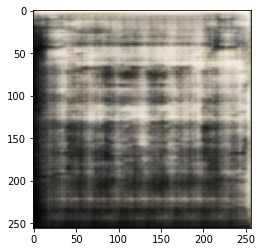

In [29]:
# example of loading a pix2pix model and using it for one-off image translation
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot
 
# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels
 
# load source image
src_image = load_image('/content/base/cmp_b0008.jpg')
print('Loaded', src_image)

with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "/content/models/model_7500.ckpt")
  print("Model restored.")
  gen_image = model.sample_generator(sess, src_image // 3).squeeze(0)
  gen_image = (gen_image + 1) / 2.0

  plt.imshow((array_to_img(gen_image)))